# Open Wheat Detection Baseline

In [30]:
import numpy as np
import pandas as pd

import time

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import albumentations as albu

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
from torch import nn
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
from torch.optim import Adam,lr_scheduler

from tqdm import tqdm_notebook, tqdm

from glob import glob

In [2]:
torch.cuda.is_available()

True

In [3]:
! ls ./global-wheat-detection

sample_submission.csv  test  train  train.csv


`1` __Preprocess the labels:__

In [4]:
train_labels = pd.read_csv('./global-wheat-detection/train.csv')

In [5]:
train_labels.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [6]:
train_fns = glob('./global-wheat-detection/train/' + '*')

# Create a dataframe with all train images
all_train_images = pd.DataFrame([fns.split('/')[-1][:-4] for fns in train_fns])
all_train_images.columns=['image_id']

# Merge all train images with the bounding boxes dataframe
all_train_images = all_train_images.merge(train_labels, on='image_id', how='left')

# replace nan values with zeros
all_train_images['bbox'] = all_train_images.bbox.fillna('[0,0,0,0]')

# split bbox column
bbox_items = all_train_images.bbox.str.split(',', expand=True)
all_train_images['bbox_xmin'] = bbox_items[0].str.strip('[ ').astype(float)
all_train_images['bbox_ymin'] = bbox_items[1].str.strip(' ').astype(float)
all_train_images['bbox_width'] = bbox_items[2].str.strip(' ').astype(float)
all_train_images['bbox_height'] = bbox_items[3].str.strip(' ]').astype(float)

In [7]:
all_train_images['bbox_area'] = all_train_images['bbox_width'] * all_train_images['bbox_height']

In [8]:
all_train_images.head()

,image_id,width,height,bbox,source,bbox_xmin,bbox_ymin,bbox_width,bbox_height,bbox_area
0,ad62f80f2,1024.0,1024.0,"[335.0, 826.0, 148.0, 103.0]",arvalis_3,335.0,826.0,148.0,103.0,15244.0
1,ad62f80f2,1024.0,1024.0,"[330.0, 448.0, 194.0, 179.0]",arvalis_3,330.0,448.0,194.0,179.0,34726.0
2,ad62f80f2,1024.0,1024.0,"[734.0, 355.0, 287.0, 151.0]",arvalis_3,734.0,355.0,287.0,151.0,43337.0
3,ad62f80f2,1024.0,1024.0,"[71.0, 0.0, 103.0, 35.0]",arvalis_3,71.0,0.0,103.0,35.0,3605.0
4,ad62f80f2,1024.0,1024.0,"[650.0, 750.0, 79.0, 166.0]",arvalis_3,650.0,750.0,79.0,166.0,13114.0


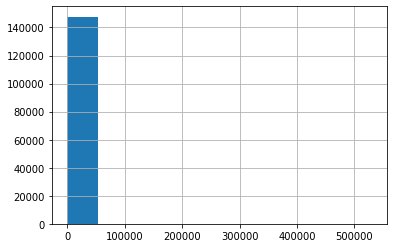

In [9]:
all_train_images.bbox_area.hist()

`2` __Remove too large and too small bounding boxes__

In [10]:
max_area_threshold = 100000
min_area_threshold = 50

In [11]:
train_labels_cleaned = all_train_images[((all_train_images.bbox_area < max_area_threshold) & (all_train_images.bbox_area > min_area_threshold)) | (all_train_images.bbox_area == 0)]

In [12]:
len(train_labels_cleaned)

147805

In [13]:
len(all_train_images)

147842

In [14]:
print("{} bounding boxes removed!".format(len(all_train_images) - len(train_labels_cleaned)))

37 bounding boxes removed!


`3` __Try to use pretrained Faster RCNN model__

https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/

In [15]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/monster/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [23]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def get_prediction(img_path, threshold):
    img = Image.open(img_path) # Load the image
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # Defing PyTorch Transform
    img = transform(img) # Apply the transform to the image
    pred = model([img]) # Pass the image to the model
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return pred_boxes, pred_class

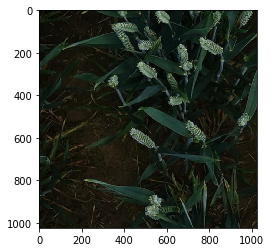

In [55]:
plt.imshow(Image.open(train_fns[1]))

In [56]:
pred_boxes, pred_class = get_prediction(train_fns[0], threshold=0.0)

In [57]:
pred_boxes

[[(28.674648, 0.0), (998.0564, 975.39124)]]

In [58]:
pred_class

['potted plant']

In [59]:
def plot_boxes(img, bboxes):
    fig, ax = plt.subplots()
    ax.imshow(img)
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0][0],bbox[0][1]),
                                 bbox[1][0] - bbox[0][0],
                                 bbox[1][1] - bbox[0][1],
                                 linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        
    plt.show()

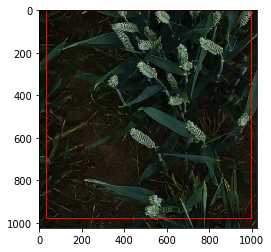

In [60]:
plot_boxes(Image.open(train_fns[1]), pred_boxes)

`4` __Train Faster RCNN model__

Examples:

https://www.kaggle.com/abhishek/training-fast-rcnn-using-torchvision

https://www.kaggle.com/arunmohan003/fasterrcnn-using-pytorch-baseline